# Classification of credit card clients


In [ ]:
## Use this for consistency in graphs through out the notebook
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as clf
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn import metrics

seed=123

In [ ]:
### Your code here

## Feel free to use multiple cells  and continue from here:

df = pd.read_excel("default of credit card clients.xls", sheet_name = 0, skiprows= 1, header = 0)

In [ ]:
cc_df=df.copy() #creating a copy of the dataframe, to avoid frequent loads
cc_df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [ ]:
cc_df.isnull().sum() # no missing values

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [ ]:
cc_df['default payment next month'].value_counts()/len(cc_df) *100

0    77.88
1    22.12
Name: default payment next month, dtype: float64

So 77.88% credit card clients will not do default payment next month <br>
and 22.12 clients will have a default payment next month

In [ ]:
# check for the correct unique values for the target variable
bal_grp=cc_df.groupby('default payment next month')[['ID']].count()
bal_grp.index.values

array([0, 1], dtype=int64)

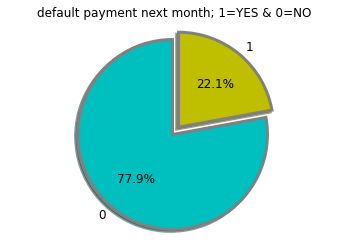

In [ ]:
#plotting target variable to visualise data balance
explode = (0.1, 0) 
plt.pie(bal_grp['ID'], labels=bal_grp.index.values,textprops={'fontsize':'large'},explode=explode,colors={'y','c'},
        wedgeprops= {"edgecolor":"gray",
                     'linewidth': 3,
                     'antialiased': True},
        autopct='%1.1f%%', shadow=True, startangle=90,)
plt.axis('equal')
plt.title('default payment next month; 1=YES & 0=NO')
plt.show();

In [ ]:
# creating separate variables for categorical, discrete and target variables
Categorical_vars=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Discrete_vars=['AGE','LIMIT_BAL','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Target_var=['default payment next month']

In [ ]:
#taking the stratified sample
smp_df=cc_df.sample(frac=0.077,random_state=123)
smp_df['default payment next month'].value_counts()/len(smp_df) *100

0    77.186147
1    22.813853
Name: default payment next month, dtype: float64

<Figure size 1440x1440 with 0 Axes>

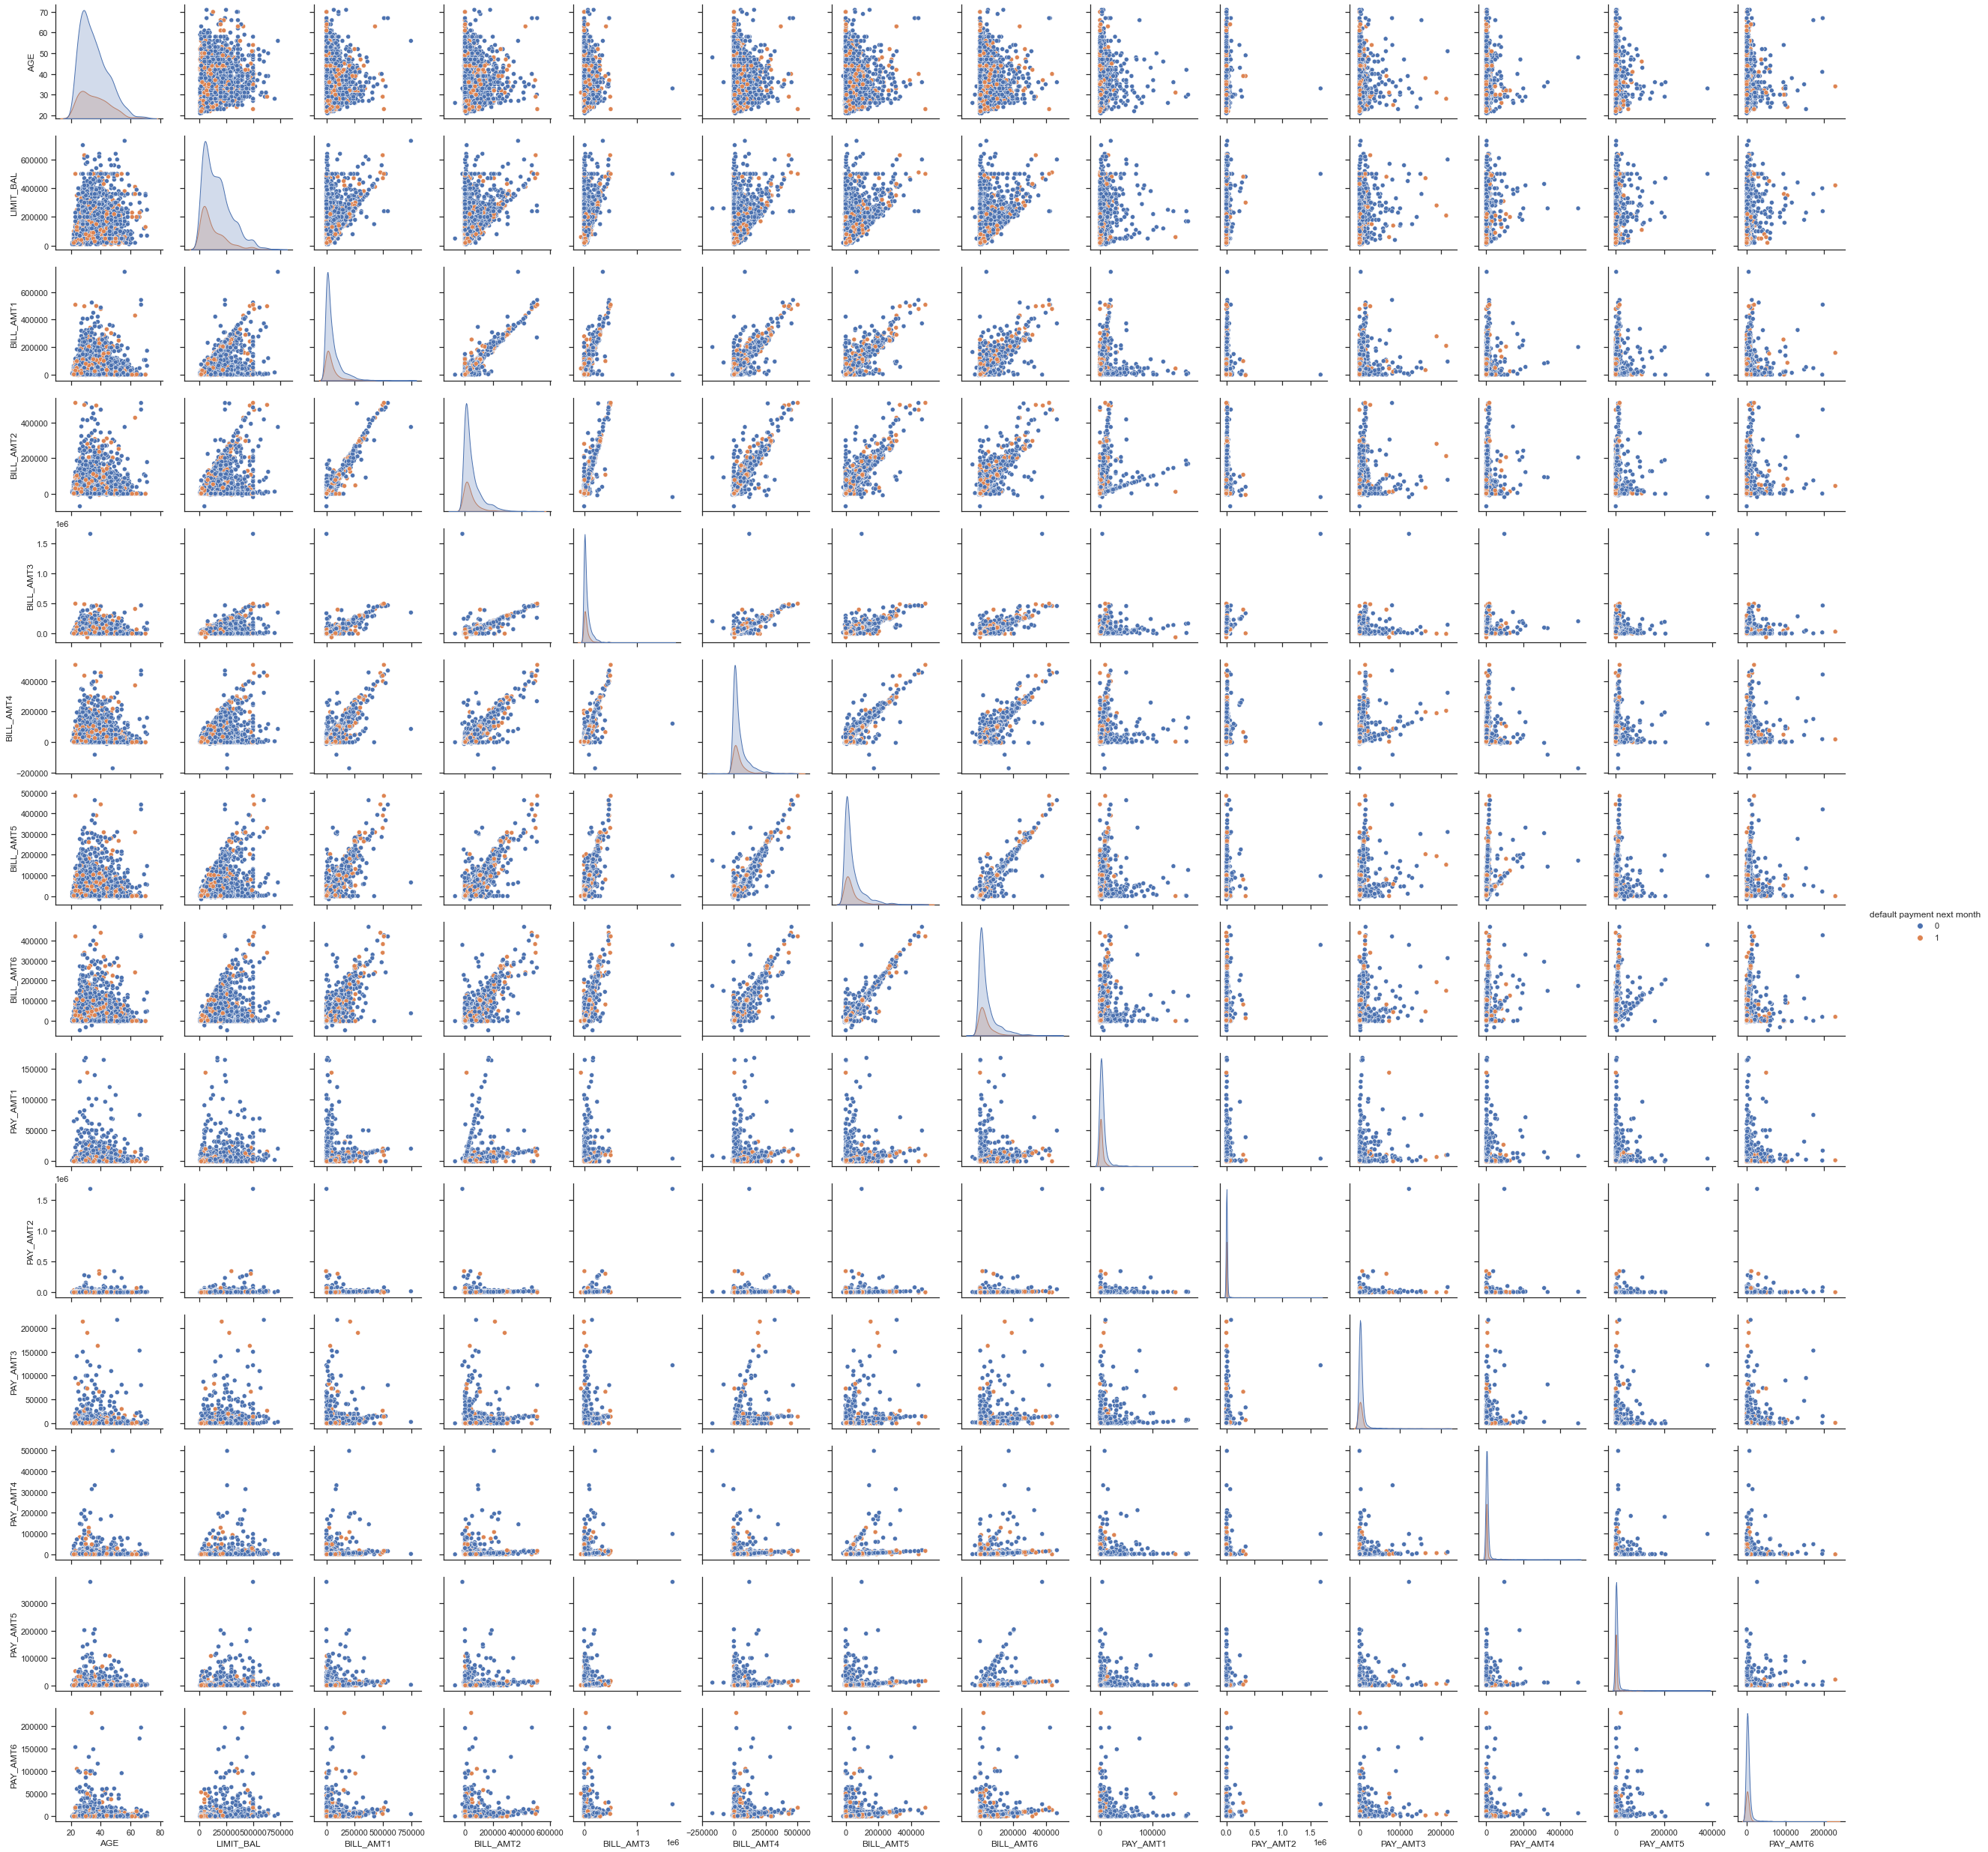

In [ ]:
# creating a pairplot of discrete variables on a stratified sample, and checking data distribution with Target variable
sns.set(style='ticks')
plt.figure(figsize=(20,20))
sns.pairplot(data=smp_df.loc[:,Discrete_vars+Target_var],hue='default payment next month')

From the visualisation, it seems that different bill_amt variable is strongly correlated to bill_amt varaibles. For example, bill_amt1 is strongly correlated (positively) with bill_amt2 and then this strength of correlation seems to decrease for bill_amt1 VS bill_amt3....6.
In other words, bill_amt of previous month and next month is most positively correlated.
lets plot just bill_amts and see this trend more clearly.

<Figure size 1440x1440 with 0 Axes>

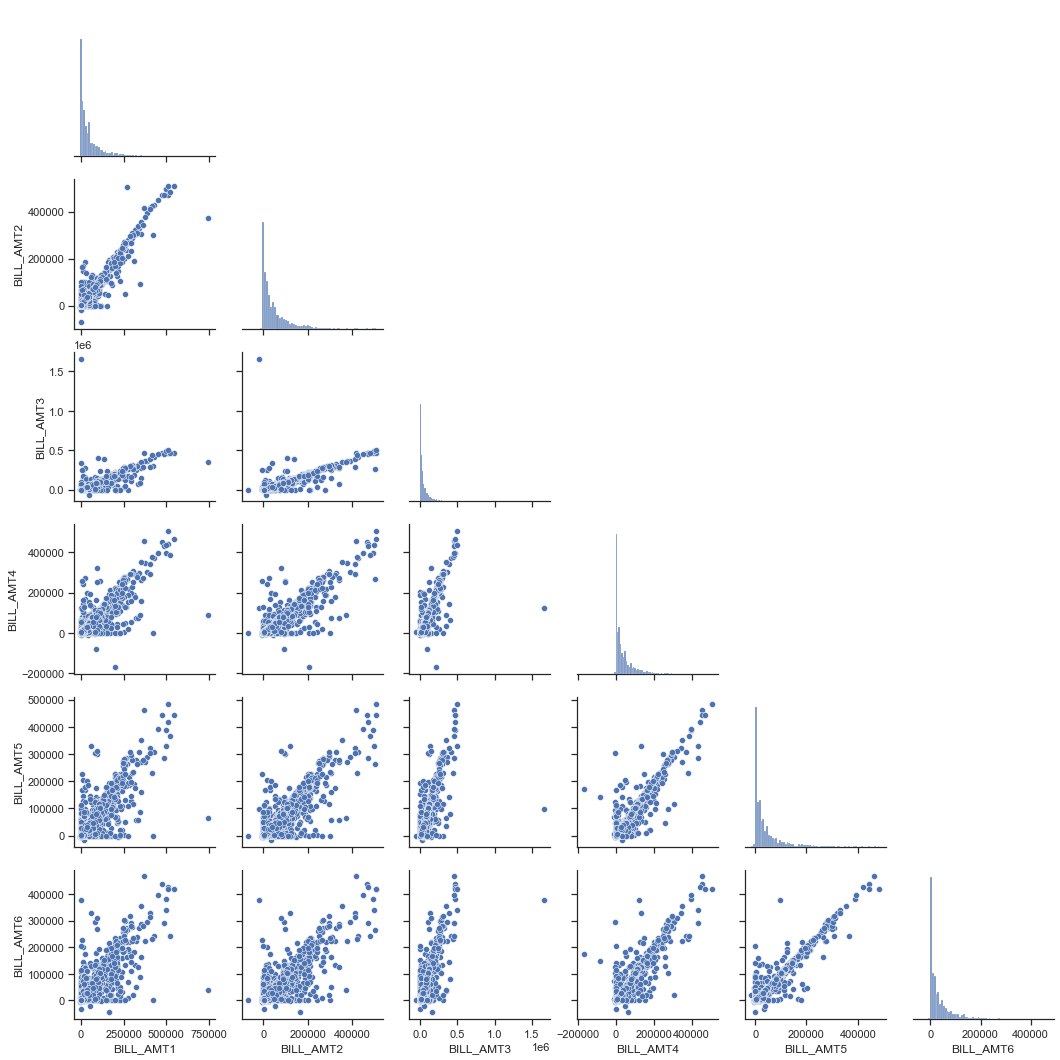

In [ ]:
#plotting just bill_amt1.....6
sns.set(style='ticks')
plt.figure(figsize=(20,20))
sns.pairplot(data=smp_df.loc[:,'BILL_AMT1':'BILL_AMT6'],corner=True);

In [ ]:
#summary of discrete variables
cc_df[Discrete_vars].describe()

,AGE,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,35.485500,167484.322667,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,9.217904,129747.661567,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,21.000000,10000.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,28.000000,50000.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,34.000000,140000.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,41.000000,240000.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,79.000000,1000000.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


Its interesting to see negative values in bill_amt1...6, which may suggest that there exists, users of credit cards, whose payments were paid and they had a credit balance to ensure due payments.

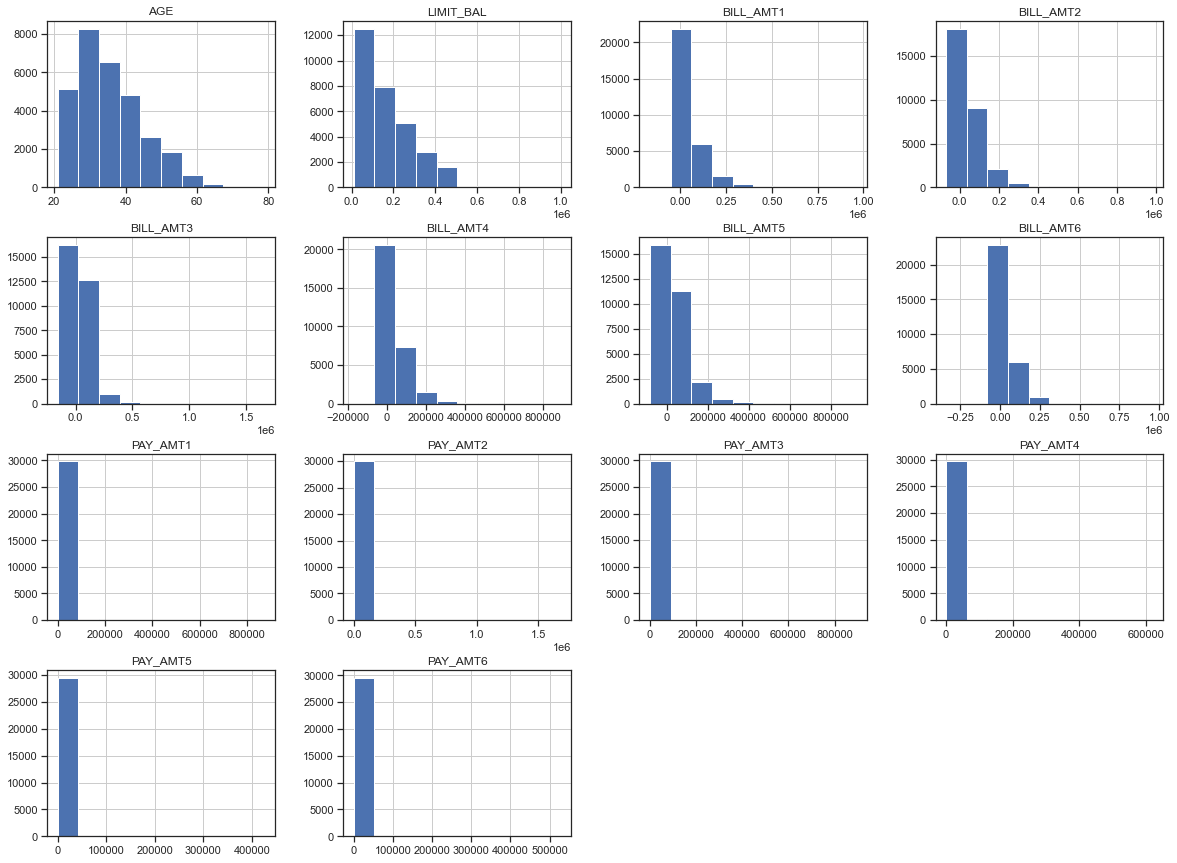

In [ ]:
#creating histograms for all discrete Variables
cc_df[Discrete_vars].hist(figsize=(20,15));

We can see, that data is not normally distributed. For instance Limit_bal may require some transformation. Similarly all the bill_amt have too high standard deviations, which again suggest data needs some transformation. Also the negative values of bill_amt need to be addressed. Pay_amt values also need some scalar transformations as the variance is huge in data.

In [ ]:
#checking unique values of categorical variables
tmp=cc_df.loc[:,'SEX': 'PAY_6'].agg(['count','unique'])
tmp

,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,"[2, 1]","[2, 1, 3, 5, 4, 6, 0]","[1, 2, 3, 0]","[24, 26, 34, 37, 57, 29, 23, 28, 35, 51, 41, 3...","[2, -1, 0, -2, 1, 3, 4, 8, 7, 5, 6]","[2, 0, -1, -2, 3, 5, 7, 4, 1, 6, 8]","[-1, 0, 2, -2, 3, 4, 6, 7, 1, 5, 8]","[-1, 0, -2, 2, 3, 4, 5, 7, 6, 1, 8]","[-2, 0, -1, 2, 3, 5, 4, 7, 8, 6]","[-2, 2, 0, -1, 3, 6, 4, 7, 8, 5]"


Education and marriage seems to have more categories than mentioned in the meta data

<AxesSubplot:xlabel='EDUCATION', ylabel='Count'>

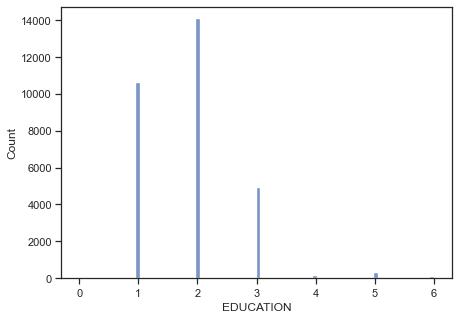

In [ ]:
fig,ax=plt.subplots(figsize=(7,5))
sns.histplot(cc_df['EDUCATION'],ax=ax)# Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
#seems like 0,4,5,6 all need to be clubbed in the 'Others'

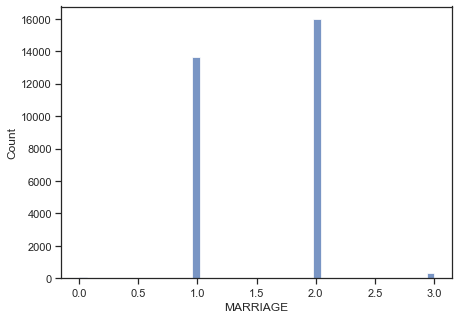

In [ ]:
fig,ax=plt.subplots(figsize=(7,5))
sns.histplot(cc_df['MARRIAGE'],ax=ax); #Marriage ((1 = married; 2 = single; 3 = others).
#However there are rows of value 0 also

In [ ]:
cc_df['AGE'].unique() # checking for adults and no inappropriate age group (such as kids)

array([24, 26, 34, 37, 57, 29, 23, 28, 35, 51, 41, 30, 49, 39, 40, 27, 47,
       33, 32, 54, 58, 22, 25, 31, 46, 42, 43, 45, 56, 44, 53, 38, 63, 36,
       52, 48, 55, 60, 50, 75, 61, 73, 59, 21, 67, 66, 62, 70, 72, 64, 65,
       71, 69, 68, 79, 74], dtype=int64)

<AxesSubplot:xlabel='AGE', ylabel='Count'>

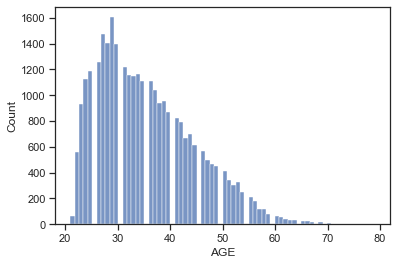

In [ ]:
sns.histplot(cc_df['AGE']) #majority of people belonged to mid 20s-mid 30s

In [ ]:
cc_df.PAY_0.unique()

array([ 2, -1,  0, -2,  1,  3,  4,  8,  7,  5,  6], dtype=int64)

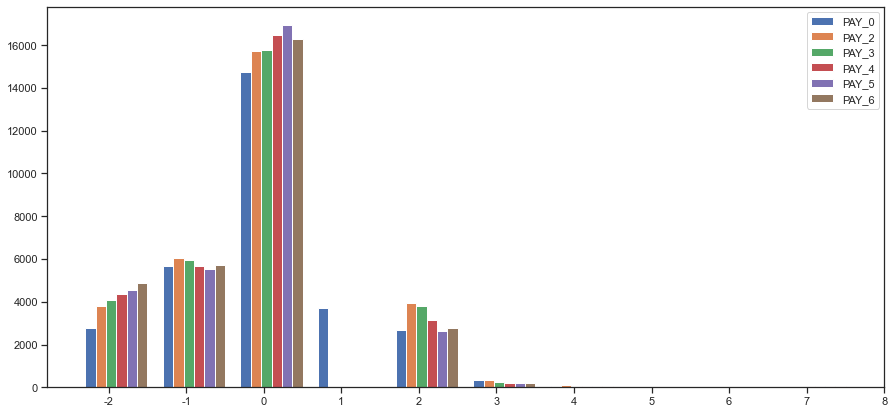

In [ ]:
#creating a histogram to see the distribution of variables PAY_0....6
fig,ax=plt.subplots(figsize=(15,7))
w=0.8
plt.hist(cc_df.loc[:,'PAY_0':'PAY_6'],label=cc_df.loc[:,'PAY_0':'PAY_6'].columns.values,rwidth=w)
plt.legend()

ax.set_xticks(ticks=np.add([-2,-1,0,1,2,3,4,5,6,7,8],w/2))


ax.set_xticklabels([-2,-1,0,1,2,3,4,5,6,7,8]);

In [ ]:
cols=cc_df.columns[6:12]
cols

Index(['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], dtype='object')

In [ ]:
tmp_df=cc_df[cols.tolist()]
tmp_df.head(2)

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2


In [ ]:
#checking the count distribution of PAY_0....6 for different values of payment status
box = tmp_df.melt()
pd.crosstab(box.value, box.variable,margins=True)

variable,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,All
value,,,,,,,
-2,2759,3782,4085,4348,4546,4895,24415
-1,5686,6050,5938,5687,5539,5740,34640
0,14737,15730,15764,16455,16947,16286,95919
1,3688,28,4,2,0,0,3722
2,2667,3927,3819,3159,2626,2766,18964
3,322,326,240,180,178,184,1430
4,76,99,76,69,84,49,453
5,26,25,21,35,17,13,137
6,11,12,23,5,4,19,74


-2 = No Consumption - Balance paid in full and no transactions this period (we may refer to this credit card account as having been 'inactive' this period)

-1 = Paid Duly - Balance paid in full, but account has a positive balance at end of period due to recent transactions for which payment has not yet come due

0 = Revolving Credit - Customer paid the minimum due amount, but not the entire balance. I.e., the customer paid enough for their account to remain in good standing, but did revolve a balance

1 = payment delay for one month
2 = payment delay for two months
3...7 = payment delay for 3...7 months
8 = payment delay for eight months; 9 = payment delay for nine months and above.

majority people had payment status of -2,-1 and 0

## Feature comparison

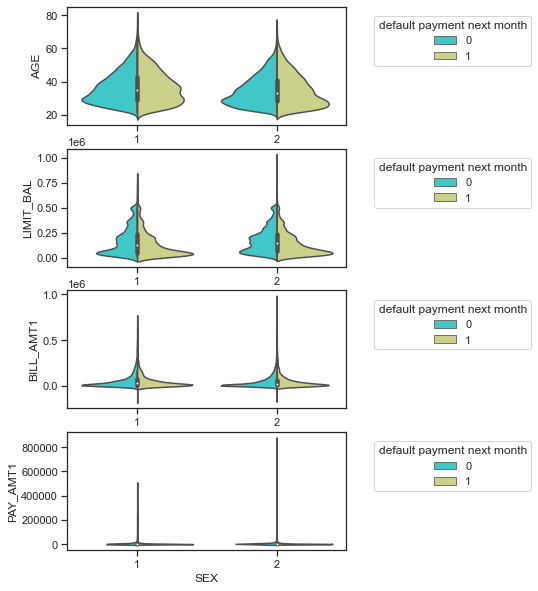

In [ ]:
fig,ax=plt.subplots(4,1,figsize=(5,10))
y_cols=['AGE','LIMIT_BAL','BILL_AMT1','PAY_AMT1']

for i,n in enumerate(y_cols):
    sns.violinplot(x='SEX',y=n,data=cc_df, hue='default payment next month', split='True', palette='rainbow',ax=ax[i])
    #plotting legends
    ax[i].legend(title='default payment next month',loc=(1.1, 0.5))

There is hardly any change in distribution based on the categories for sex.

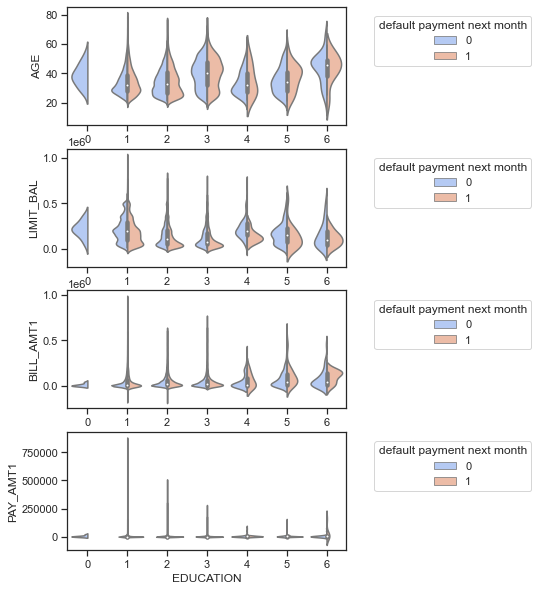

In [ ]:
fig,ax=plt.subplots(4,1,figsize=(5,10))
y_cols=['AGE','LIMIT_BAL','BILL_AMT1','PAY_AMT1']

for i,n in enumerate(y_cols):
    sns.violinplot(x='EDUCATION',y=n,data=cc_df, hue='default payment next month', split='True', palette='coolwarm',ax=ax[i])
    #plotting legends
    ax[i].legend(title='default payment next month',loc=(1.1, 0.5))

Education seems to have impact on the numerical variables, as distribution curve varies for different categories of education

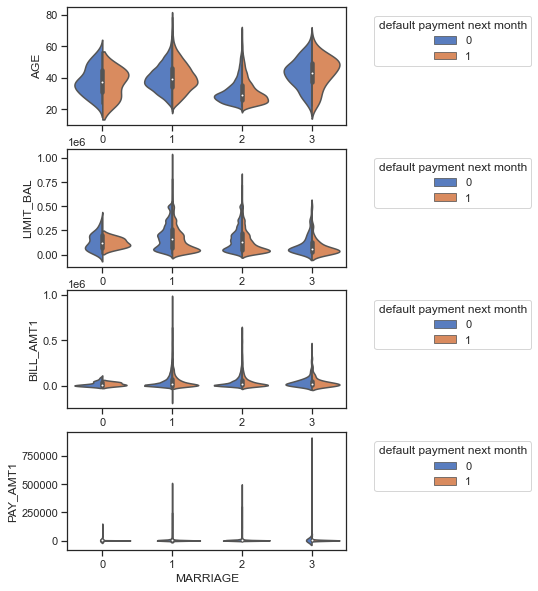

In [ ]:
fig,ax=plt.subplots(4,1,figsize=(5,10))
y_cols=['AGE','LIMIT_BAL','BILL_AMT1','PAY_AMT1']

for i,n in enumerate(y_cols):
    sns.violinplot(x='MARRIAGE',y=n,data=cc_df, hue='default payment next month', split='True', palette='muted',ax=ax[i])
    #plotting legends
    ax[i].legend(title='default payment next month',loc=(1.1, 0.5))

Marriage doesnt seem to have any difference in distribution for most of discrete variables, but since it shows a difference in distribution for PAY_AMT1, so we can decide to keep it.

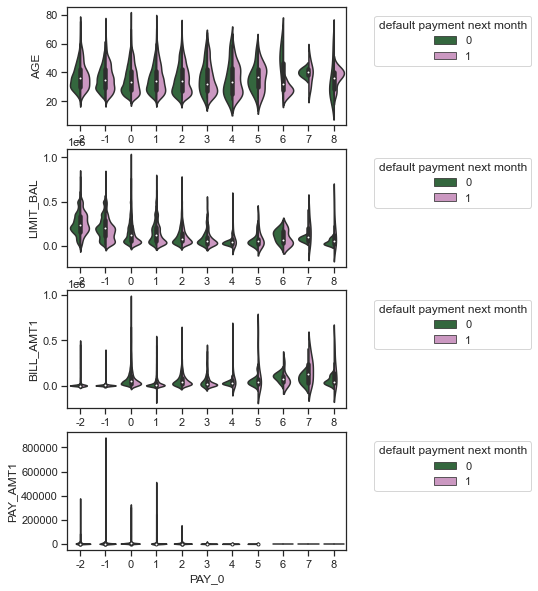

In [ ]:
fig,ax=plt.subplots(4,1,figsize=(5,10))
y_cols=['AGE','LIMIT_BAL','BILL_AMT1','PAY_AMT1']

for i,n in enumerate(y_cols):
    sns.violinplot(x='PAY_0',y=n,data=cc_df, hue='default payment next month', split='True', palette='cubehelix',ax=ax[i])
    #plotting legends
    ax[i].legend(title='default payment next month',loc=(1.1, 0.5))

We conclude that PAY_0....6, Marriage & Eduation can be useful variables.

## Creating Train & Test data sets

In [ ]:
categorical_vars=['EDUCATION','MARRIAGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [ ]:
X=cc_df[categorical_vars+Discrete_vars]
y=cc_df[Target_var]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y) #stratified sampling based on the target
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (24000, 22)
X_test.shape: (6000, 22)
y_train.shape: (24000, 1)
y_test.shape: (6000, 1)


In [ ]:
train_counts=y_train['default payment next month'].value_counts()
test_counts=y_test['default payment next month'].value_counts()
print(train_counts)
print(test_counts)

0    18691
1     5309
Name: default payment next month, dtype: int64
0    4673
1    1327
Name: default payment next month, dtype: int64


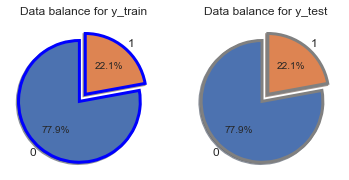

In [ ]:
# check data balance for y_train & y_test
fig,ax=plt.subplots(1,2)
sns.set_palette('hls')
explode = (0.1,0.05)
ax[0].pie(train_counts, explode=explode,labels=train_counts.index,
        wedgeprops= {"edgecolor":"blue",
                     'linewidth': 3,
                     'antialiased': True},
        autopct='%1.1f%%', shadow=True, startangle=90,)

ax[1].pie(test_counts, explode=explode,labels=test_counts.index,
        wedgeprops= {"edgecolor":"grey",
                     'linewidth': 3,
                     'antialiased': True},
        autopct='%1.1f%%', shadow=True, startangle=90,)

ax[0].set_title('Data balance for y_train')

ax[1].set_title('Data balance for y_test');

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin #classes to inherit from when building custom transformers
class mar_edu(BaseEstimator, TransformerMixin):
    def __init__(self,val=[]):
        self.val=val
        
    def fit(self, X, y=None):
        if (len(self.val[0]) > 0):
            X=self.edu_mar_trans(X)
        return self
   
    def edu_mar_trans(self, X,y=None):
        X[self.val[0]]=X[self.val[0]].map(lambda x: 4 if (x<1 or x>4) else x)
        X[self.val[1]]=X[self.val[1]].map(lambda t: 3 if (t<1) else t)
        return X
    
    def transform(self, X,y=None):
        X[self.val[0]]=X[self.val[0]].map(lambda x: 4 if (x<1 or x>4) else x)
        X[self.val[1]]=X[self.val[1]].map(lambda t: 3 if (t<1) else t)
        return X
       

In [ ]:
print(X_train.EDUCATION.unique())
print(X_train.MARRIAGE.unique())

[3 1 2 4 5 0 6]
[1 2 0 3]


In [ ]:
Discrete_vars

['AGE',
 'LIMIT_BAL',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [ ]:
std_discrete_vars=['AGE','LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
mm_discrete_vars=['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [ ]:
preprocessor = make_column_transformer(
    (StandardScaler(),std_discrete_vars),
    (MinMaxScaler(),mm_discrete_vars),
    (OneHotEncoder(), categorical_vars))

In [ ]:
pipe_full=Pipeline([
    ('edu_mar_trans',mar_edu(val=['EDUCATION','MARRIAGE'])),
    ('cat_dis',preprocessor)])


In [ ]:
pipe_full

Pipeline(steps=[('edu_mar_trans', mar_edu(val=['EDUCATION', 'MARRIAGE'])),
                ('cat_dis',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['AGE', 'LIMIT_BAL',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['EDUCATION', 'MARRIAGE',
                                                   'PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5',
                                                   'PAY_6'])]))])

In [ ]:
pipe_full.fit(X_train,y_train)

Pipeline(steps=[('edu_mar_trans', mar_edu(val=['EDUCATION', 'MARRIAGE'])),
                ('cat_dis',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['AGE', 'LIMIT_BAL',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['EDUCATION', 'MARRIAGE',
                                                   'PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5',
                                                   'PAY_6'])]))])

In [ ]:
X_train_transformed = pipe_full.transform(X_train)
X_test_transformed = pipe_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

X_train_transformed.shape: (24000, 85)
X_test_transformed.shape: (6000, 85)


In [ ]:
STD_discrete_vars=pipe_full.named_steps['cat_dis'].named_transformers_['standardscaler'].get_feature_names_out(std_discrete_vars)
print(f'Total Discrete vars with standard transformation: {len(STD_discrete_vars)}')
print(STD_discrete_vars)

Total Discrete vars with standard transformation: 8
['AGE' 'LIMIT_BAL' 'BILL_AMT1' 'BILL_AMT2' 'BILL_AMT3' 'BILL_AMT4'
 'BILL_AMT5' 'BILL_AMT6']


In [ ]:
MM_discrete_vars=pipe_full.named_steps['cat_dis'].named_transformers_['minmaxscaler'].get_feature_names_out(mm_discrete_vars)
print(f'Total Discrete vars with minmax transformation: {len(MM_discrete_vars)}')
print(MM_discrete_vars)

Total Discrete vars with minmax transformation: 6
['PAY_AMT1' 'PAY_AMT2' 'PAY_AMT3' 'PAY_AMT4' 'PAY_AMT5' 'PAY_AMT6']


In [ ]:
total_cat_vars=pipe_full.named_steps['cat_dis'].named_transformers_['onehotencoder'].get_feature_names_out(categorical_vars)
print(f'Total Categorical vars: {len(total_cat_vars)}')
print(total_cat_vars)

Total Categorical vars: 71
['EDUCATION_1' 'EDUCATION_2' 'EDUCATION_3' 'EDUCATION_4' 'MARRIAGE_1'
 'MARRIAGE_2' 'MARRIAGE_3' 'PAY_0_-2' 'PAY_0_-1' 'PAY_0_0' 'PAY_0_1'
 'PAY_0_2' 'PAY_0_3' 'PAY_0_4' 'PAY_0_5' 'PAY_0_6' 'PAY_0_7' 'PAY_0_8'
 'PAY_2_-2' 'PAY_2_-1' 'PAY_2_0' 'PAY_2_1' 'PAY_2_2' 'PAY_2_3' 'PAY_2_4'
 'PAY_2_5' 'PAY_2_6' 'PAY_2_7' 'PAY_2_8' 'PAY_3_-2' 'PAY_3_-1' 'PAY_3_0'
 'PAY_3_1' 'PAY_3_2' 'PAY_3_3' 'PAY_3_4' 'PAY_3_5' 'PAY_3_6' 'PAY_3_7'
 'PAY_3_8' 'PAY_4_-2' 'PAY_4_-1' 'PAY_4_0' 'PAY_4_1' 'PAY_4_2' 'PAY_4_3'
 'PAY_4_4' 'PAY_4_5' 'PAY_4_6' 'PAY_4_7' 'PAY_4_8' 'PAY_5_-2' 'PAY_5_-1'
 'PAY_5_0' 'PAY_5_2' 'PAY_5_3' 'PAY_5_4' 'PAY_5_5' 'PAY_5_6' 'PAY_5_7'
 'PAY_5_8' 'PAY_6_-2' 'PAY_6_-1' 'PAY_6_0' 'PAY_6_2' 'PAY_6_3' 'PAY_6_4'
 'PAY_6_5' 'PAY_6_6' 'PAY_6_7' 'PAY_6_8']


# Random Forest Classification

In [ ]:
simple_rfc=clf(random_state=seed)
results = cross_val_score(simple_rfc, X_train_transformed,np.ravel(y_train), cv=5)

In [ ]:
print('Cross Validation Score for Random Forest: {0}'.format(results.mean()))

Cross Validation Score for Random Forest: 0.8154999999999999


# Hyperparameter tunning using GridSearchCV - Random Forest

In [ ]:
#Initialising parameters for GridSearchCV
n_estimators=[4, 5, 10, 20, 50]
rfc_grid={'n_estimators':n_estimators}

In [ ]:
rfc_grid

{'n_estimators': [4, 5, 10, 20, 50]}

In [ ]:
model_rfc=clf(random_state=seed)
rf_grid=GridSearchCV(estimator=model_rfc,param_grid=rfc_grid,cv=5,verbose=1,scoring='roc_auc')

In [ ]:
%%time
rf_grid.fit(X_train_transformed,np.ravel(y_train)) #Fitting GridSearchCV on X_train_transformed & y_train

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 3min 5s
Wall time: 3min 6s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'n_estimators': [4, 5, 10, 20, 50]}, scoring='roc_auc',
             verbose=1)

In [ ]:
rf_grid.best_params_  ## the best n_estimator

{'n_estimators': 50}

In [ ]:
# This is basically the roc_auc value as we set scoring as 'roc_auc'
print(f'Accuracy of X_trained: {rf_grid.score(X_train_transformed,np.ravel(y_train))}')
print(f'Accuracy of X_test: {rf_grid.score(X_test_transformed,np.ravel(y_test))}')

Accuracy of X_trained: 0.9999591456334114
Accuracy of X_test: 0.7553615335157428


In [ ]:
#using the best estimator in GridSearchCV of Random forest classifier, predicting target values with test data
rf_y_predict = rf_grid.best_estimator_.predict(X_test_transformed) 

Test accuracy for Random Forest Classifier after hyperparameter tunning: 80.92 %


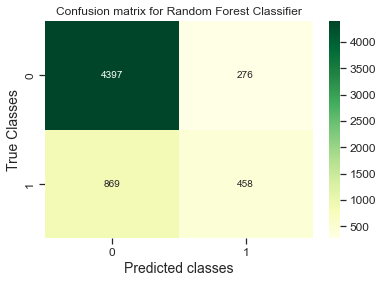

In [ ]:
# Plotting confusion matrix
print('Test accuracy for Random Forest Classifier after hyperparameter tunning:'\
      , round(accuracy_score(y_test,rf_y_predict)*100, 2), '%')
plt.title('Confusion matrix for Random Forest Classifier')
sns.heatmap(confusion_matrix(y_test,rf_y_predict), annot=True, cmap="YlGn",fmt="d")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
#preparing for roc_curve using rf_grid.best_estimator_.predict_proba()
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_grid.best_estimator_.predict_proba(X_test_transformed)[:,1])

In [ ]:
rf_roc_auc_score=roc_auc_score(y_test, rf_grid.best_estimator_.predict_proba(X_test_transformed)[:,1])

In [ ]:
rf_roc_auc_score

0.7553615335157428

ROC_AUC_score for Random Forest classfication after hyperparameter tunning: 0.75536


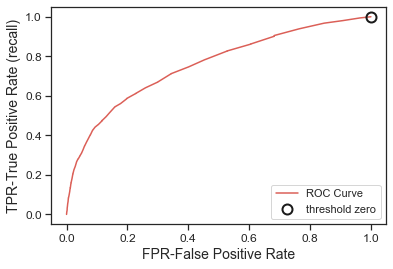

In [ ]:
# Plotting ROC curve along with area under curve
print('ROC_AUC_score for Random Forest classfication after hyperparameter tunning: {0}'.format(round(rf_roc_auc_score,5)))
plt.plot(rf_fpr, rf_tpr, label="ROC Curve")

plt.xlabel("FPR-False Positive Rate")
plt.ylabel("TPR-True Positive Rate (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(rf_thresholds))
plt.plot(rf_fpr[close_zero], rf_tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

# KNN Classification

In [ ]:
simple_knn=knn()
results2 = cross_val_score(simple_knn, X_train_transformed,np.ravel(y_train), cv=5)

In [ ]:
print('Cross Validation Score for KNN: {0}'.format(results2.mean()))

Cross Validation Score for KNN: 0.79375


# Hyperparameter tunning using GridSearchCV - KNN

In [ ]:
# Initialising parameters for GridSearchCV on KNN
n_neighbors=[3,5,10,20]
knn_param_grid={'n_neighbors':n_neighbors}

In [ ]:
# Initialising KNN model and knn_grid
model_knn=knn()
knn_grid=GridSearchCV(estimator=model_knn,param_grid=knn_param_grid,cv=5,verbose=1,return_train_score=True,scoring='roc_auc')

In [ ]:
%%time
knn_grid.fit(X_train_transformed,np.ravel(y_train)) ## calling knn_grid.fit on X_train_transformed & y_train

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: total: 5min 9s
Wall time: 5min 12s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 10, 20]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [ ]:
knn_grid.best_params_ # the best n_neighbor for KNN

{'n_neighbors': 20}

In [ ]:
# This is basically the roc_auc value as we set scoring as 'roc_auc'
print(f'Accuracy of X_trained: {knn_grid.score(X_train_transformed,np.ravel(y_train))}')
print(f'Accuracy of X_test: {knn_grid.score(X_test_transformed,np.ravel(y_test))}')

Accuracy of X_trained: 0.8087080699436833
Accuracy of X_test: 0.747356545345151


In [ ]:
#using the best estimator in GridSearchCV of KNN classifier, predicting target values with test data
knn_y_predict = knn_grid.best_estimator_.predict(X_test_transformed) 

Test accuracy for KNN Classifier after hyperparameter tunning: 81.17 %


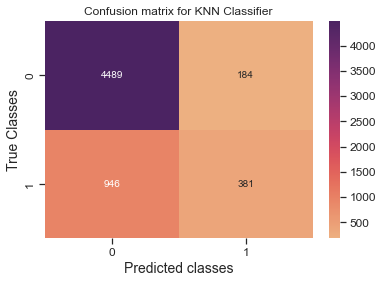

In [ ]:
# Plotting confusion matrix
print('Test accuracy for KNN Classifier after hyperparameter tunning:'\
      , round(accuracy_score(y_test,knn_y_predict)*100, 2), '%')
plt.title('Confusion matrix for KNN Classifier')
sns.heatmap(confusion_matrix(np.ravel(y_test),knn_y_predict), annot=True, cmap="flare",fmt="d")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
#preparing for roc_curve using rf_grid.best_estimator_.predict_proba()
fpr, tpr, thresholds = roc_curve(y_test, knn_grid.best_estimator_.predict_proba(X_test_transformed)[:,1])

In [ ]:
knn_roc_auc_score=roc_auc_score(y_test, knn_grid.best_estimator_.predict_proba(X_test_transformed)[:,1])

In [ ]:
knn_roc_auc_score

0.747356545345151

ROC_AUC_score for KNN classfication after hyperparameter tunning: 0.74736


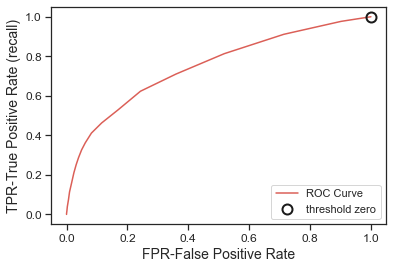

In [ ]:
# Plotting ROC curve along with area under curve
print('ROC_AUC_score for KNN classfication after hyperparameter tunning: {0}'.format(round(knn_roc_auc_score,5)))
plt.plot(fpr, tpr, label="ROC Curve")

plt.xlabel("FPR-False Positive Rate")
plt.ylabel("TPR-True Positive Rate (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

# Analysis of Random Forest Classifier & KNN Classifier using Precision & Recall

In [ ]:
rf_conf_metr = confusion_matrix(y_test, rf_y_predict)
rf_senstivity=rf_conf_metr[1,1]/(rf_conf_metr[1,1]+rf_conf_metr[1,0])
rf_precision=rf_conf_metr[1,1]/(rf_conf_metr[1,1]+rf_conf_metr[0,1])
rf_f1=(2*(rf_senstivity*rf_precision))/(rf_senstivity+rf_precision)


print("Confusion Matrix for Random Forest: \n {}".format(rf_conf_metr))

print("Accuracy:",metrics.accuracy_score(y_test,  rf_y_predict))
print("Recall/Sensitivity/True Positive Rate:",round(rf_senstivity,4))
print("Precision:",round(rf_precision,4))
print('KNN Roc_auc_score',round(rf_roc_auc_score,4))
print('F1 for Random Forest:',round(rf_f1,3))

Confusion Matrix for Random Forest: 
 [[4397  276]
 [ 869  458]]
Accuracy: 0.8091666666666667
Recall/Sensitivity/True Positive Rate: 0.3451
Precision: 0.624
KNN Roc_auc_score 0.7554
F1 for Random Forest: 0.444


In [ ]:
knn_conf_metr = confusion_matrix(np.ravel(y_test), knn_y_predict)
knn_senstivity=knn_conf_metr[1,1]/(knn_conf_metr[1,1]+knn_conf_metr[1,0])
knn_precision=knn_conf_metr[1,1]/(knn_conf_metr[1,1]+knn_conf_metr[0,1])
knn_f1=(2*(knn_senstivity*knn_precision))/(knn_senstivity+knn_precision)

print("Confusion Matrix for KNN classification: \n {}".format(knn_conf_metr))

print("Accuracy:",metrics.accuracy_score(y_test,  knn_y_predict))
print("Recall/Sensitivity/True Positive Rate:",round(knn_senstivity,4))
print("Precision:",round(knn_precision,4))
print('KNN Roc_auc_score',round(knn_roc_auc_score,4))
print('F1 for KNN:',round(knn_f1,3))

Confusion Matrix for KNN classification: 
 [[4489  184]
 [ 946  381]]
Accuracy: 0.8116666666666666
Recall/Sensitivity/True Positive Rate: 0.2871
Precision: 0.6743
KNN Roc_auc_score 0.7474
F1 for KNN: 0.403


# Conclusions

So in this data set we used Random Forest & KNN classification to predict the credit card default in the next month. For this scenario, a high recall and precision both are very important.As both higher false negative rate or false positive rate may result a huge loss to the bank. In case of wrongly predicting a non defaulting customer as a defaulter, bank may end up loosing valuable customers of future and in case of wrongly predicting a defaulter a non defaulter may cause the bank to default it self.

Therefore the best model should be more concerned with correct prediction of minority class i.e. default next month=1.

Since Sensitivity is the proportion of true positives that are correctly identified, so its higher value is definitely better. We can see that since recall is higher for Random forest therefore also resulting in a smaller value of precision in comparison to the precision score of KNN. So even though KNN has a little higher accuracy than Random forest, but the Recall or sensitivity of Random Forest is better than KNN. Generally when the data is unbalanced like this one, the model performance is better judged by F1 score, which is basically a weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. And so, f1 score of Random Forest is better than KNN.

This is also evident from area under curve (ROC_AUC_SCORE), as random forest has better ROC_AUC.
Also cross validation score of KNN is less than Random Forest, so Random Forest performed better.